## pip installs

In [1]:
!pip install Levenshtein
!pip install einops
!pip install einops_exts
!pip install torch
!pip install transformers
!pip install tqdm
!pip install sentencepiece
!pip install black
!pip install fair-esm
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.8 MB/s eta 0:00:00


## dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import re
import esm
from einops import rearrange, repeat
import math
import numpy as np
from torch import einsum
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import wandb
wandb.login()
import os
os.chdir('/content/drive/MyDrive/Programmable Biology Group/Srikar/flamingo-diffusion/data_dump/old_dat/')

# ESM Model Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

esm_model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
esm_model = esm_model.to(device)
esm_model.eval()
for param in esm_model.parameters():
    param.requires_grad = False

# Data Preprocessing
def preprocess_snp_data(file_path):
    snp_df = pd.read_csv(file_path)

    def transform_energy_scores(energy_scores):
        transformed_scores = []
        for score in energy_scores:
            score = re.sub(r'[\s\n]+', ',', score)
            score = re.sub(r'\[\s*,', '[', score)
            score = re.sub(r'^[\s,]+', '', score)
            transformed_scores.append(score)
        return transformed_scores

    snp_df['energy_scores'] = transform_energy_scores(snp_df['energy_scores'])
    snp_df['energy_scores_lengths'] = snp_df['energy_scores'].apply(
        lambda x: x.count(',') + 1 - (1 if x.startswith(',') else 0)
    )

    snp_df['peptide_source_RCSB_lengths'] = snp_df['peptide_source_RCSB'].apply(len)
    snp_df['protein_RCSB_lengths'] = snp_df['protein_RCSB'].apply(len)
    snp_df['protein_derived_seq_length'] = snp_df['protein_derived_sequence'].apply(len)
    snp_df['peptide_derived_seq_length'] = snp_df['peptide_derived_sequence'].apply(len)

    return snp_df

def filter_datasets(dataset):
    return dataset[dataset['protein_RCSB'] != dataset['peptide_source_RCSB']]

# Dataset Class
class ProteinInteractionDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.mismatched_lengths = 0
        self.total_samples = len(dataframe)
        self.check_lengths()

    def check_lengths(self):
        for idx in range(self.total_samples):
            row = self.dataframe.iloc[idx]
            peptide_seq = row['peptide_derived_sequence']
            energy_scores = row['energy_scores']

            energy_scores = re.findall(r'-?\d+\.?\d*(?:e[-+]?\d+)?', energy_scores)
            energy_scores = [float(score) for score in energy_scores]

            if len(energy_scores) != len(peptide_seq):
                self.mismatched_lengths += 1

        print(f"Total samples: {self.total_samples}")
        print(f"Mismatched lengths: {self.mismatched_lengths}")

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        peptide_seq = row['peptide_derived_sequence']
        protein_seq = row['protein_derived_sequence']
        energy_scores = row['energy_scores']

        energy_scores = re.findall(r'-?\d+\.?\d*(?:e[-+]?\d+)?', energy_scores)
        energy_scores = [float(score) for score in energy_scores]
        energy_scores = self.one_hot_encode_energy_scores(energy_scores)

        # Convert energy scores to tensor
        energy_scores = torch.tensor(energy_scores, dtype=torch.float32)

        return energy_scores, peptide_seq, protein_seq # energy scores are aligned with the peptide (we will keep peptide as protien)

    @staticmethod
    def one_hot_encode_energy_scores(scores):
        return [1 if score <= -1 else 0 for score in scores]



<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


In [4]:

# Load and preprocess data
train_snp = preprocess_snp_data('training_dataset.csv')
val_snp = preprocess_snp_data('validation_dataset.csv')
test_snp = preprocess_snp_data('testing_dataset.csv')

train_snp = filter_datasets(train_snp)
val_snp = filter_datasets(val_snp)
test_snp = filter_datasets(test_snp)

train_snp, val_snp, test_snp = train_snp[:16], val_snp[16:24], test_snp[24:32] # subset code

# Calculate max_length
all_seqs = pd.concat([
    train_snp['peptide_derived_sequence'], train_snp['protein_derived_sequence'],
    val_snp['peptide_derived_sequence'], val_snp['protein_derived_sequence'],
    test_snp['peptide_derived_sequence'], test_snp['protein_derived_sequence']
])
max_length = max(len(seq) for seq in all_seqs)

# Create datasets
train_dataset = ProteinInteractionDataset(train_snp)
val_dataset = ProteinInteractionDataset(val_snp)
test_dataset = ProteinInteractionDataset(test_snp)

Total samples: 16
Mismatched lengths: 0
Total samples: 8
Mismatched lengths: 0
Total samples: 8
Mismatched lengths: 0


In [5]:
for i in range(5):  # Adjust range to view more samples
    energy_scores, protein_seq, peptide_seq = train_dataset[i]
    print(f"Sample {i}:")

    # Print energy scores and their length
    print(f"Energy Scores: {energy_scores}")
    print(f"Length of Energy Scores: {energy_scores.shape[0]}")

    # Print protein sequence and its length
    print(f"Protein Sequence: {protein_seq}")
    print(f"Length of Protein Sequence: {len(protein_seq)}")

    # Print peptide sequence and its length
    print(f"Peptide Sequence: {peptide_seq}")
    print(f"Length of Peptide Sequence: {len(peptide_seq)}")

    print("\n")

Sample 0:
Energy Scores: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.,

## model

In [6]:
from einops import reduce


Total samples: 32
Mismatched lengths: 0
Total samples: 16
Mismatched lengths: 0
Total samples: 16
Mismatched lengths: 0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch,▁█
train_ce_loss,▁█
train_clip_loss,█▁
train_diff_loss,▁█
train_loss,▁█
val_ce_loss,█▁
val_clip_loss,█▁
val_diff_loss,█▁
val_loss,█▁
epoch,2
train_ce_loss,4.61357


CLIP Epoch 1/2:   0%|          | 0/16 [00:00<?, ?it/s]<ipython-input-10-2979545277c5>:535: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_energy_scores = [F.pad(torch.tensor(score, dtype=torch.float32), (1, 1), value=0) for score in energy_scores]
<ipython-input-10-2979545277c5>:535: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_energy_scores = [F.pad(torch.tensor(score, dtype=torch.float32), (1, 1), value=0) for score in energy_scores]
<ipython-input-10-2979545277c5>:535: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_

CLIP Epoch 1, Train Loss: 0.6929, Val Loss: 0.6932


CLIP Epoch 2/2:   0%|          | 0/16 [00:00<?, ?it/s]<ipython-input-10-2979545277c5>:535: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_energy_scores = [F.pad(torch.tensor(score, dtype=torch.float32), (1, 1), value=0) for score in energy_scores]
<ipython-input-10-2979545277c5>:535: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_energy_scores = [F.pad(torch.tensor(score, dtype=torch.float32), (1, 1), value=0) for score in energy_scores]
<ipython-input-10-2979545277c5>:535: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_

CLIP Epoch 2, Train Loss: 0.6929, Val Loss: 0.6931


clip_train_loss,█▁
clip_val_loss,█▁
epoch,▁█
clip_train_loss,0.69292
clip_val_loss,0.69314
epoch,2


Epoch 1/2:   0%|          | 0/16 [00:00<?, ?it/s]<ipython-input-10-2979545277c5>:535: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_energy_scores = [F.pad(torch.tensor(score, dtype=torch.float32), (1, 1), value=0) for score in energy_scores]
<ipython-input-10-2979545277c5>:535: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_energy_scores = [F.pad(torch.tensor(score, dtype=torch.float32), (1, 1), value=0) for score in energy_scores]
<ipython-input-10-2979545277c5>:535: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_energ

diff losses noise tensor([[[ 0.0732, -0.2021,  1.0232,  ...,  0.2652, -0.1121, -0.3209],
         [ 0.1720, -0.7881,  0.3673,  ...,  1.6525,  0.9268, -0.4953],
         [-0.1673,  1.9410,  1.8666,  ...,  1.3755,  1.3214,  0.7574],
         ...,
         [ 0.4280, -0.3974, -0.6015,  ...,  0.4538, -0.1635,  0.1952],
         [ 0.5458, -0.4649, -0.0464,  ...,  1.2896, -1.0493,  0.0263],
         [ 0.4132, -1.8092, -0.7840,  ..., -0.6751,  0.7916,  0.2907]],

        [[ 1.4178, -0.8159,  1.4735,  ..., -0.9894,  0.2139, -0.2662],
         [-0.5440, -0.2995, -0.5789,  ...,  0.6645,  0.2801,  0.2502],
         [-0.0889,  0.1477, -0.5135,  ..., -0.3772, -0.8773,  1.3404],
         ...,
         [ 0.9553, -0.8378, -1.4707,  ..., -0.2191,  2.5326,  0.3141],
         [-0.5247,  0.2365, -0.5531,  ...,  0.3488,  0.9311,  0.1401],
         [ 2.2106,  1.0692,  1.6998,  ...,  0.0434,  0.1194,  1.3308]]],
       device='cuda:0')
diff losses pred noise tensor([[[-0.1177, -0.5207,  0.4638,  ..., -0.2440,

Epoch 1/2:   6%|▋         | 1/16 [00:01<00:22,  1.48s/it]

diff losses noise tensor([[[-0.9617,  0.1894,  0.9788,  ..., -0.5152,  1.1937, -0.7792],
         [ 1.7520,  1.6443, -1.7601,  ..., -0.4550, -0.4607, -0.2752],
         [ 1.7549, -1.2186, -0.4896,  ..., -0.3643,  1.1238, -0.1725],
         ...,
         [-1.6297, -0.6906,  0.0675,  ..., -1.2601,  0.1830, -0.9362],
         [ 1.8196,  0.7820,  0.4635,  ..., -2.0538, -1.2017, -0.6054],
         [ 2.7779, -0.7843,  1.1315,  ...,  1.4378,  0.3681, -0.0411]],

        [[ 0.7082, -0.8803, -0.2283,  ...,  0.8879, -0.5346,  0.3824],
         [ 0.7596, -0.5101, -0.3611,  ...,  0.4532, -0.0966,  0.6514],
         [-1.4053,  0.4568,  0.0571,  ..., -0.2204,  0.6253,  0.8026],
         ...,
         [ 1.8053, -0.4346, -0.5448,  ..., -0.3703,  0.6908,  1.4224],
         [-0.1119,  0.1105, -1.5531,  ...,  0.3609,  0.6242, -0.2818],
         [ 1.5076,  0.2723,  0.2131,  ...,  0.3240, -0.3077,  0.4216]]],
       device='cuda:0')
diff losses pred noise tensor([[[-3.2047e-01, -4.6178e-01, -1.5107e-02,  .

Epoch 1/2:  12%|█▎        | 2/16 [00:02<00:16,  1.19s/it]

diff losses noise 

Epoch 1/2:  19%|█▉        | 3/16 [00:03<00:12,  1.04it/s]

tensor([[[ 1.1312e+00, -5.4775e-01,  1.2492e+00,  ..., -3.5457e-01,
           3.1230e-01,  4.4374e-01],
         [ 1.0557e+00, -1.7312e+00,  1.8027e+00,  ..., -6.9280e-01,
          -9.5155e-01,  2.9963e-01],
         [-6.9859e-02, -4.4744e-01,  5.0655e-01,  ..., -1.2629e+00,
           9.9074e-01, -8.5257e-01],
         ...,
         [ 7.9792e-01,  7.0007e-01, -1.0463e+00,  ...,  1.5066e+00,
           6.4399e-03,  6.0046e-01],
         [ 2.1412e-01,  4.6378e-01, -4.4900e-01,  ...,  8.5698e-01,
           2.3526e-01,  2.3941e-01],
         [-9.8105e-01, -1.4752e+00,  7.4469e-01,  ..., -3.9451e-01,
           9.5521e-01, -1.8571e+00]],

        [[-5.8362e-01, -3.8479e-01, -1.0553e+00,  ..., -8.8975e-01,
           6.8993e-01,  7.3780e-01],
         [-9.8805e-01, -1.4208e-01, -1.0232e+00,  ..., -1.1278e+00,
           1.1555e+00, -7.3783e-01],
         [-8.0556e-01,  7.1352e-01, -1.9353e-01,  ..., -1.0521e-01,
          -5.8193e-01, -1.1199e+00],
         ...,
         [-5.5116e-01,  1

Epoch 1/2:  25%|██▌       | 4/16 [00:04<00:11,  1.03it/s]

diff losses noise tensor([[[ 0.0773, -0.6819, -0.0090,  ..., -0.3491,  0.1009,  0.7724],
         [ 0.2199,  0.2998,  1.3403,  ..., -0.2251,  0.9847,  1.5589],
         [ 1.2741, -0.2020, -1.5466,  ...,  1.0793,  0.3211,  0.1929],
         ...,
         [ 0.8301, -1.3770, -0.4269,  ..., -0.8953,  0.7762, -0.4363],
         [-0.1214, -0.7418, -0.5604,  ..., -0.9035,  0.8098,  0.2325],
         [-0.8546, -0.7461,  0.0395,  ...,  0.1096, -0.7162,  0.4272]],

        [[-0.0082,  1.4355, -0.7875,  ...,  0.4134,  0.6936,  0.8042],
         [-1.7088,  0.8903,  0.1037,  ..., -0.0867,  0.5686,  0.7002],
         [ 0.6508,  2.1177, -0.3854,  ...,  0.1004, -0.2381,  1.5892],
         ...,
         [-1.9296, -0.9132,  1.5045,  ...,  0.1321,  1.8953, -0.8686],
         [-0.9251,  1.2130,  0.0933,  ..., -0.3759, -2.9999, -0.7747],
         [-1.8301, -0.1076, -0.1086,  ...,  2.0988,  1.8576,  0.8616]]],
       device='cuda:0')
diff losses pred noise tensor([[[ 1.1706, -0.4647,  1.0369,  ...,  0.0846,

Epoch 1/2:  31%|███▏      | 5/16 [00:05<00:10,  1.02it/s]

diff losses noise tensor([[[ 0.3793, -0.7284, -0.7347,  ...,  0.1815,  2.1521,  0.0962],
         [-1.3766,  0.7418, -0.8266,  ..., -0.5365,  2.0860,  0.0850],
         [-1.8954, -0.9957,  1.1361,  ...,  0.2895, -0.1526,  1.1812],
         ...,
         [-0.9193,  0.9376,  1.6172,  ...,  0.5652,  1.3195,  0.5665],
         [-0.9986,  0.4382, -1.7421,  ..., -0.5875,  1.1265, -0.3770],
         [-0.0214,  0.4420,  0.2893,  ...,  0.4140,  0.0426, -0.8705]],

        [[ 0.0037,  0.4730,  0.3917,  ...,  2.3269,  0.1652,  0.6786],
         [-0.4752, -0.6908,  0.2826,  ..., -0.2117, -0.6270, -1.4486],
         [ 1.4396, -0.6823,  0.4272,  ...,  1.7040,  0.1452,  0.1937],
         ...,
         [ 1.2394, -1.2028, -0.3851,  ...,  0.7494, -1.7759, -1.1985],
         [ 0.5742,  0.2562, -2.0120,  ..., -0.0379,  1.2831,  0.3470],
         [ 0.2577, -0.1392,  0.0275,  ..., -0.1993, -0.6312,  0.4099]]],
       device='cuda:0')
diff losses pred noise tensor([[[ 0.9076, -0.2965,  1.2945,  ..., -0.2096,

Epoch 1/2:  38%|███▊      | 6/16 [00:06<00:10,  1.05s/it]

diff losses noise tensor([[[ 2.1170, -1.2664,  0.2866,  ...,  1.1253,  1.3840,  0.6536],
         [ 0.0623, -0.1840, -0.4744,  ..., -0.3082, -0.2150, -0.2127],
         [-0.4370, -0.6190, -0.3069,  ...,  1.3274, -0.3420, -0.1062],
         ...,
         [ 1.5951,  0.3080, -0.6914,  ..., -0.8238,  0.0380, -0.4682],
         [ 1.4362,  1.4588, -1.1773,  ...,  0.6046, -0.6016,  1.8846],
         [-0.0323,  1.5328,  0.2178,  ...,  0.6852, -1.3530, -0.2352]],

        [[ 1.3037,  1.3117, -0.0384,  ...,  1.3304, -0.5175, -0.0477],
         [ 1.1235, -0.8398, -0.2928,  ..., -0.8170,  0.2564, -1.3061],
         [-2.1878, -1.1049, -1.5171,  ..., -1.4191, -0.2324,  0.7879],
         ...,
         [ 1.3546, -1.4800, -0.2362,  ...,  0.2037,  3.5497,  0.2887],
         [-1.4815, -1.1414, -1.5578,  ..., -1.0953,  0.1885, -0.4094],
         [ 1.3932, -0.5857,  1.4673,  ..., -0.5772,  0.5247, -0.7843]]],
       device='cuda:0')
diff losses pred noise tensor([[[ 0.6449, -0.4884,  0.8139,  ..., -0.4702,

Epoch 1/2:  44%|████▍     | 7/16 [00:07<00:09,  1.04s/it]

diff losses noise tensor([[[-1.4499, -2.4071,  0.2123,  ..., -0.2135, -0.1374, -0.1209],
         [-0.5442,  0.0742, -1.0001,  ..., -0.4006,  0.2279, -2.0636],
         [ 0.1900,  0.3787, -1.1652,  ..., -0.5696,  2.0029,  1.7233],
         ...,
         [ 0.4962,  2.0594,  2.0920,  ...,  1.1544,  0.2345,  0.1054],
         [-0.3694,  0.3499, -0.7310,  ...,  0.4875, -1.4030, -0.6749],
         [ 1.5916, -0.9684,  0.8044,  ..., -0.4778,  0.3371,  0.1291]],

        [[ 1.0718, -0.7166,  0.4004,  ...,  0.2143, -0.7187,  1.6102],
         [ 1.0891, -0.2393,  2.8786,  ...,  0.0596, -0.2715, -0.5696],
         [ 1.6194, -0.3156,  0.0322,  ..., -1.3549,  0.0458, -0.0557],
         ...,
         [-0.1924, -1.4347,  0.2085,  ..., -0.7869, -1.2879,  0.1765],
         [-0.5936,  0.1930,  1.5952,  ..., -1.8955, -0.8511,  0.0656],
         [-0.0167, -0.0857,  0.1031,  ...,  0.7077, -0.7899,  1.0475]]],
       device='cuda:0')
diff losses pred noise tensor([[[ 0.7765, -0.5716,  0.8383,  ..., -0.1119,

Epoch 1/2:  50%|█████     | 8/16 [00:08<00:09,  1.17s/it]

diff losses noise 

Epoch 1/2:  56%|█████▋    | 9/16 [00:09<00:07,  1.04s/it]

tensor([[[-1.5909e+00,  3.7890e-01, -1.0446e+00,  ...,  7.2050e-01,
          -2.2739e-02,  1.3206e+00],
         [-1.0425e+00,  8.6197e-01, -9.1807e-01,  ...,  1.5203e+00,
           8.3523e-01, -3.5985e-01],
         [-2.3669e+00,  6.6233e-01, -3.4664e-01,  ..., -1.5554e+00,
          -6.2188e-02, -3.4949e-01],
         ...,
         [-5.5414e-01,  6.9356e-01, -2.5339e+00,  ...,  1.3413e+00,
           2.2266e-01, -7.2856e-02],
         [ 1.7908e-01,  3.2036e+00, -1.4303e+00,  ..., -3.9421e-01,
          -1.1792e+00, -6.9070e-02],
         [-6.1539e-01, -1.1607e+00,  4.3757e-01,  ..., -2.5715e-01,
          -1.3840e+00, -1.6126e+00]],

        [[-7.8780e-01,  8.0636e-01, -7.7415e-01,  ...,  8.8090e-01,
           9.2976e-01,  3.4487e-01],
         [ 3.7930e-01, -8.6625e-01, -2.9679e-01,  ...,  6.8406e-01,
           4.3653e-01,  4.0260e-01],
         [-6.7690e-01, -1.3008e-01, -3.5919e-04,  ..., -1.1568e+00,
           7.0394e-01,  2.0929e-01],
         ...,
         [ 2.1868e-01, -1

Epoch 1/2:  62%|██████▎   | 10/16 [00:10<00:05,  1.05it/s]

tensor([[[-1.5510,  0.0211, -0.8153,  ...,  1.3542, -0.1889,  1.1765],
         [-0.9619, -0.0456,  1.2585,  ..., -0.5876, -0.8954, -1.4473],
         [ 1.0856,  0.5799,  1.6939,  ..., -0.2450, -0.1352,  1.0329],
         ...,
         [ 0.5492, -1.1217,  0.5455,  ...,  0.7368,  0.2405, -1.2201],
         [-0.3791,  0.8606, -1.1420,  ..., -1.1321,  0.1516, -0.0168],
         [ 0.3946,  0.1799, -1.6184,  ...,  0.1959, -0.1833,  3.1949]],

        [[-0.3944,  1.5434, -0.2689,  ..., -0.0851,  0.3729,  0.7511],
         [-1.3514,  1.1760, -1.9298,  ..., -0.9314, -0.1175, -0.6155],
         [ 0.2700, -2.1133,  0.1119,  ..., -0.0496, -1.2443,  0.7569],
         ...,
         [ 0.5651, -0.7134, -0.3155,  ..., -0.0889,  0.8549,  0.5976],
         [-0.1249, -0.8682,  0.8773,  ..., -0.5341,  0.2749, -1.3617],
         [-0.9345,  0.6710,  0.3124,  ..., -0.1466, -0.4451, -0.0643]]],
       device='cuda:0')
diff losses pred noise tensor([[[ 0.4642, -0.4577,  0.7415,  ..., -0.0145, -0.2235, -0.1010]

Epoch 1/2:  69%|██████▉   | 11/16 [00:11<00:05,  1.03s/it]

diff losses noise tensor([[[ 0.3187, -1.4668,  1.1875,  ...,  2.7515, -0.5587,  0.9300],
         [-2.1512, -1.2385,  0.3095,  ...,  0.6390, -0.2413,  0.4261],
         [-0.4438, -1.3110,  0.3211,  ...,  0.6703,  1.4199,  0.1224],
         ...,
         [-1.1901,  0.0444,  0.6535,  ..., -0.2674,  0.8107,  0.9169],
         [-0.6913,  0.6795,  1.0565,  ..., -2.4169,  0.9182, -0.5767],
         [ 1.0700,  0.6060, -0.2179,  ...,  3.2635, -0.1309, -0.6610]],

        [[-0.4437,  0.7151,  0.0773,  ...,  0.5465, -0.2925, -0.8010],
         [-0.9042, -0.6987, -0.1297,  ..., -1.1596, -0.5910,  0.1208],
         [-2.4442,  0.5480,  0.3359,  ..., -0.8361,  1.4133,  0.2649],
         ...,
         [ 0.5906, -0.7118, -0.7483,  ..., -1.1464, -0.5247,  0.6380],
         [ 1.4598, -0.8921,  2.7691,  ..., -0.6879,  0.2355, -1.6032],
         [-1.6549,  1.1789,  0.2145,  ..., -0.3455,  0.8847,  1.0235]]],
       device='cuda:0')
diff losses pred noise tensor([[[-0.3058, -0.2764,  0.4491,  ..., -0.1478,

Epoch 1/2:  75%|███████▌  | 12/16 [00:12<00:03,  1.10it/s]

diff losses noise tensor([[[-0.9183, -1.5954,  0.3130,  ...,  0.2978, -1.2637, -0.8767],
         [-0.4048,  0.7796,  0.4652,  ..., -0.5226, -0.4700,  0.6244],
         [ 0.3483,  1.3067,  0.1948,  ..., -0.3868, -0.8209,  0.0661],
         ...,
         [ 0.8655, -1.2729, -0.2150,  ..., -0.1913,  0.8943,  0.6664],
         [-0.6280,  0.2801, -0.5274,  ...,  0.9253,  2.0564,  0.9922],
         [-1.8957, -0.8451,  1.5372,  ...,  0.9571,  1.3052,  0.5705]],

        [[-0.0403,  1.3268, -0.0675,  ..., -0.2024,  0.2464,  0.0397],
         [-0.5631, -0.4675,  0.0687,  ...,  0.5517,  0.5907, -0.9469],
         [ 0.5750, -0.6090, -0.4896,  ..., -2.0821, -0.2317,  0.9030],
         ...,
         [-1.4135,  0.7318,  0.2415,  ...,  0.5092,  0.0262, -0.4958],
         [ 0.9335, -0.4103,  0.1507,  ...,  0.3791, -0.5448,  1.4236],
         [-0.2579,  0.0964,  1.0522,  ...,  0.0974,  0.3610,  1.1080]]],
       device='cuda:0')
diff losses pred noise tensor([[[ 1.0730, -0.2394,  1.1579,  ..., -0.1276,

Epoch 1/2:  81%|████████▏ | 13/16 [00:14<00:04,  1.42s/it]

diff losses noise 

Epoch 1/2:  88%|████████▊ | 14/16 [00:15<00:02,  1.23s/it]

tensor([[[ 0.0866, -1.1497, -1.9467,  ..., -0.2004, -0.3996, -1.5285],
         [-1.0205, -0.9408,  0.7097,  ..., -2.0968,  1.4921,  0.6615],
         [ 0.0281, -0.8575, -0.1201,  ...,  2.5750, -0.6611,  0.0137],
         ...,
         [ 0.0228,  2.8383, -1.0350,  ...,  1.4055,  0.5478, -0.7141],
         [ 0.7285, -1.1925,  1.5308,  ..., -0.6306,  0.0252, -0.1895],
         [-1.5917, -0.1190,  1.2865,  ..., -0.1156, -0.4083, -0.2243]],

        [[-1.3548,  0.4578, -0.0308,  ..., -0.2954,  1.1052,  0.9431],
         [ 0.8436, -0.8872,  0.7553,  ..., -0.3175,  1.1516,  0.4741],
         [-1.5490, -0.5166,  1.2491,  ..., -1.9863,  0.8660,  0.5503],
         ...,
         [ 1.0818, -0.6983,  1.6763,  ..., -1.2191, -1.9062, -0.0544],
         [-1.6464, -0.9092,  0.2294,  ...,  0.4895, -0.8471,  0.1294],
         [-0.4986, -0.3234,  1.8191,  ...,  1.6041,  0.2919, -0.5323]]],
       device='cuda:0')
diff losses pred noise tensor([[[-0.0443, -0.6065,  0.6265,  ..., -0.3038,  0.2302,  0.4060]

Epoch 1/2:  94%|█████████▍| 15/16 [00:16<00:01,  1.02s/it]

diff losses noise tensor([[[ 0.5095, -1.9787, -1.1941,  ..., -0.0843, -1.1899, -0.0637],
         [ 0.6278,  0.3430, -0.3370,  ...,  0.2257, -0.1606,  1.6388],
         [-0.3852, -1.6411,  1.1113,  ...,  0.5207, -0.5039, -0.7304],
         ...,
         [-0.8228, -1.0730, -0.0664,  ...,  0.7574, -0.7449,  0.4701],
         [-0.7368,  0.1790,  0.8997,  ...,  0.4002, -1.7245,  0.6692],
         [ 0.4433,  0.7936,  0.5391,  ...,  0.7707,  0.5904,  0.4369]],

        [[ 1.1012,  0.5553, -1.3164,  ...,  0.8391, -0.1321,  0.5925],
         [ 0.7778, -1.4524, -1.0277,  ..., -0.4474, -1.4276, -2.3788],
         [ 0.0157, -0.9739, -0.1765,  ...,  0.0126,  0.9128,  0.5947],
         ...,
         [-0.1552, -0.1689, -0.9897,  ...,  0.5634,  2.1202, -0.4149],
         [-0.3900, -0.2462, -0.9022,  ...,  0.5664, -1.0123, -0.8375],
         [-0.0597,  1.8203,  2.3155,  ...,  1.3286,  0.5609,  0.3460]]],
       device='cuda:0')
diff losses pred noise tensor([[[ 1.1237, -0.1795,  1.3923,  ..., -0.0973,

Epoch 1/2: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]
<ipython-input-10-2979545277c5>:535: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_energy_scores = [F.pad(torch.tensor(score, dtype=torch.float32), (1, 1), value=0) for score in energy_scores]
<ipython-input-10-2979545277c5>:535: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_energy_scores = [F.pad(torch.tensor(score, dtype=torch.float32), (1, 1), value=0) for score in energy_scores]
<ipython-input-10-2979545277c5>:535: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pa

diff losses noise tensor([[[ 2.3526,  0.1770,  0.9003,  ...,  0.3956, -0.5676, -0.9833],
         [-0.1325, -0.2998, -0.0283,  ..., -1.4187,  0.2027,  0.6592],
         [ 0.3677, -0.0096, -1.8341,  ..., -0.7006, -1.4607,  0.6320],
         ...,
         [ 0.3864,  0.7195,  0.6013,  ...,  0.4879,  0.6473, -0.1976],
         [ 1.2960, -0.4093, -1.1549,  ...,  2.1640,  0.1839,  0.4597],
         [-0.5057, -1.3066,  0.2101,  ..., -0.9084, -2.6864, -0.3045]],

        [[ 0.4520,  0.3621,  2.5601,  ..., -0.6881,  0.2054, -1.8583],
         [ 0.4742,  0.6623, -0.1499,  ...,  0.5925,  1.4402, -0.5643],
         [-1.8258, -0.1037, -0.0610,  ...,  0.6927,  0.1113,  0.1782],
         ...,
         [-0.7524,  0.8802, -0.3477,  ...,  0.5988, -0.8411,  0.0870],
         [ 2.5388, -1.1571, -1.2970,  ...,  0.0222, -0.8297,  0.9040],
         [ 1.0119, -0.3134, -0.4792,  ..., -1.7029,  0.6845,  0.5370]]],
       device='cuda:0')
diff losses pred noise tensor([[[ 0.6523, -0.4934,  0.8803,  ..., -0.5743,

Epoch 2/2:   0%|          | 0/16 [00:00<?, ?it/s]<ipython-input-10-2979545277c5>:535: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_energy_scores = [F.pad(torch.tensor(score, dtype=torch.float32), (1, 1), value=0) for score in energy_scores]
<ipython-input-10-2979545277c5>:535: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_energy_scores = [F.pad(torch.tensor(score, dtype=torch.float32), (1, 1), value=0) for score in energy_scores]
<ipython-input-10-2979545277c5>:535: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_energ

diff losses noise 

Epoch 2/2:   6%|▋         | 1/16 [00:01<00:15,  1.02s/it]

tensor([[[ 1.3821,  0.8817,  0.1539,  ...,  0.9003,  0.9768,  0.9396],
         [-1.3366,  0.1920,  1.4416,  ..., -1.6486, -1.5726,  0.8740],
         [-0.5263,  0.5445,  0.6224,  ..., -1.6161,  1.4830, -0.1544],
         ...,
         [ 0.4698, -0.4183, -0.7562,  ...,  0.4389, -0.4965,  0.2410],
         [ 0.4212,  0.5840, -1.8616,  ...,  0.1761,  1.3326, -1.3349],
         [-1.0075,  0.1248, -0.5753,  ..., -0.3747, -1.4291,  0.5955]],

        [[-1.2877, -0.7869,  1.8368,  ...,  1.1521, -1.4277, -1.1303],
         [-1.4666,  1.6456,  1.3689,  ...,  1.4646, -0.3484, -0.5707],
         [-1.0107,  0.1681,  2.4322,  ..., -0.9044,  0.1149,  0.3093],
         ...,
         [ 1.6553, -1.1163,  0.7396,  ...,  0.0612, -0.6016, -1.3332],
         [ 0.4710, -0.6345,  2.2056,  ...,  0.8025,  0.0092, -0.5473],
         [ 0.5605,  0.4413,  0.3586,  ...,  0.3977, -2.1490, -0.1481]]],
       device='cuda:0')
diff losses pred noise tensor([[[-0.7529, -0.3280, -0.0984,  ..., -0.3277,  0.1642,  1.4530]

Epoch 2/2:  12%|█▎        | 2/16 [00:01<00:09,  1.44it/s]

diff losses noise tensor([[[ 2.5359e+00,  2.0166e-01,  9.7098e-01,  ..., -6.1722e-01,
           7.5738e-02, -1.1445e+00],
         [ 2.8516e-01,  1.9159e+00,  3.6009e-01,  ..., -1.7681e+00,
           5.0792e-01, -7.8175e-01],
         [-2.1085e-02, -6.9240e-01,  2.6470e+00,  ..., -9.9460e-01,
           3.9611e-01, -1.2402e+00],
         ...,
         [-2.0018e-04, -5.0264e-01, -8.4094e-01,  ...,  5.7085e-01,
          -1.2388e+00,  1.0785e+00],
         [-7.7838e-01,  1.5246e+00, -2.8887e-01,  ...,  4.8821e-01,
          -4.4781e-02,  5.9562e-01],
         [ 6.5318e-01,  1.1601e+00, -6.4696e-01,  ..., -2.1194e+00,
           1.6491e+00,  1.7950e+00]],

        [[ 1.0527e+00,  2.5398e-01, -8.0457e-02,  ..., -2.8291e+00,
           2.2120e+00, -1.2719e+00],
         [-1.0629e+00,  3.8110e-01,  1.6553e-01,  ...,  3.5783e-01,
          -1.3447e+00, -2.7622e-01],
         [ 9.9803e-01,  9.5535e-01,  2.0289e+00,  ...,  7.0876e-01,
          -1.1216e+00,  8.2968e-01],
         ...,
       

Epoch 2/2:  19%|█▉        | 3/16 [00:02<00:12,  1.08it/s]

diff losses noise tensor([[[ 0.3717,  0.4857,  1.4267,  ...,  1.3464,  1.4458,  1.1155],
         [-0.2656, -0.1764, -0.6085,  ..., -1.2139, -0.1080,  0.1275],
         [-2.4643,  0.7759, -0.7267,  ..., -1.7775, -0.6742,  0.2061],
         ...,
         [ 0.0780, -0.2413,  0.4900,  ..., -0.9178, -0.0318, -1.6439],
         [ 1.0193,  1.9512, -0.4873,  ..., -0.6585,  0.2128, -0.3047],
         [-1.0484,  1.2851, -0.7814,  ...,  1.1599,  1.2244, -0.8363]],

        [[-0.7599,  0.7550,  1.1408,  ...,  1.2183,  0.7411,  1.8628],
         [ 1.2425,  0.2062, -1.8313,  ..., -0.2526, -0.3072,  1.6040],
         [ 2.7177, -0.1087, -1.4595,  ..., -0.5655,  0.5694, -0.1062],
         ...,
         [-0.6348,  0.2096, -1.1494,  ..., -1.1309,  0.8578, -0.0325],
         [ 2.2009,  0.1647, -0.5689,  ..., -0.3905,  0.1274, -1.4001],
         [-0.5740, -0.5253, -0.2902,  ..., -0.8955,  0.0791,  0.3016]]],
       device='cuda:0')
diff losses pred noise tensor([[[ 0.5314, -0.3289,  1.1635,  ..., -0.1599,

Epoch 2/2:  25%|██▌       | 4/16 [00:03<00:09,  1.28it/s]

diff losses noise tensor([[[ 6.6478e-01, -5.2244e-01, -1.5295e-01,  ..., -2.0473e-01,
          -1.3900e-01,  7.9576e-01],
         [-1.1570e+00,  1.1560e-01, -4.1718e-01,  ..., -1.0515e+00,
           4.6063e-01,  2.0161e+00],
         [-1.1803e+00,  3.8866e-02,  6.3250e-01,  ...,  1.5842e+00,
          -8.1596e-01, -4.5839e-01],
         ...,
         [-3.8114e-01, -5.1100e-01,  4.8862e-01,  ..., -5.5679e-01,
           4.9914e-01, -1.3565e+00],
         [-1.8631e-01,  1.3542e-02, -6.9676e-01,  ...,  1.2140e+00,
          -5.9348e-01, -1.8737e-01],
         [ 4.9493e-01, -6.3279e-01,  5.4615e-01,  ..., -4.7924e-03,
           1.0585e-01, -1.1415e+00]],

        [[ 3.8332e-01,  2.5140e+00, -1.6230e+00,  ...,  3.5783e-01,
          -1.2784e-01,  8.8104e-01],
         [-3.3696e-02,  8.9940e-01,  6.1028e-01,  ..., -1.5905e+00,
           2.2821e+00, -1.7418e+00],
         [ 1.4981e+00, -1.1268e+00, -9.4858e-01,  ..., -9.2141e-01,
          -4.7516e-01, -3.8965e-01],
         ...,
       

Epoch 2/2:  31%|███▏      | 5/16 [00:04<00:10,  1.08it/s]

diff losses noise tensor([[[ 0.0591, -0.1298,  0.7044,  ..., -1.6036, -0.2811,  1.4716],
         [-0.8548,  0.9432, -1.3156,  ..., -0.3218, -0.8020, -1.7151],
         [-0.7034,  0.8377, -0.5642,  ...,  0.9583,  1.3939,  0.0270],
         ...,
         [ 0.3377,  0.0546, -0.7185,  ..., -0.9845, -2.8696,  0.8124],
         [ 1.0671, -0.1728,  0.3730,  ..., -0.2580,  0.2983, -2.1777],
         [ 1.2875,  1.1065, -0.1472,  ..., -1.1040,  0.1952,  0.3261]],

        [[-0.4556, -1.0568,  1.0139,  ...,  1.0636,  0.7770, -1.0516],
         [ 1.0300,  0.4158,  1.1818,  ..., -1.4558, -0.5815,  0.4330],
         [ 1.2281, -1.2368,  0.2305,  ..., -0.9166, -0.6928,  1.4312],
         ...,
         [-2.3788,  0.5724, -0.5170,  ...,  1.2259,  0.8386, -0.0175],
         [-0.8409,  0.1718, -1.2092,  ..., -0.3797, -1.4207, -1.3194],
         [-1.5895,  0.0620,  0.4149,  ..., -0.4992, -0.3170,  0.8756]]],
       device='cuda:0')
diff losses pred noise tensor([[[ 0.5409, -0.2127,  0.8432,  ...,  0.0371,

Epoch 2/2:  38%|███▊      | 6/16 [00:05<00:09,  1.05it/s]

diff losses noise tensor([[[ 1.5697,  0.5498,  0.7316,  ..., -0.1697, -0.5567,  0.4840],
         [ 0.6392, -0.9335, -0.8470,  ..., -1.3609,  0.8486,  0.2678],
         [ 0.0334, -0.8946,  0.4166,  ...,  0.1547,  1.7327,  0.0336],
         ...,
         [ 1.3874,  1.9229,  0.1925,  ...,  0.9724,  0.5604, -0.9580],
         [-0.9727,  0.9589, -0.5915,  ...,  1.6453, -0.5461,  1.1033],
         [-0.5654,  0.3578, -0.2954,  ..., -0.0048,  0.1341, -0.9589]],

        [[-0.3087, -0.2174,  0.7173,  ..., -0.5178, -0.2685, -0.1521],
         [-1.1606, -0.8316, -1.1280,  ...,  0.0590,  0.2645, -0.1820],
         [ 0.8097,  0.6434,  0.0517,  ..., -0.7555, -1.4706,  0.7924],
         ...,
         [-1.6919,  0.7080,  1.3542,  ...,  1.6986, -1.6678, -0.4181],
         [ 2.2563,  0.2707,  1.2261,  ...,  1.3976, -0.5849,  0.4229],
         [-0.4722,  0.6008,  0.4871,  ..., -0.0851,  0.2104,  1.4147]]],
       device='cuda:0')
diff losses pred noise tensor([[[ 0.6522, -0.1007,  1.1203,  ..., -0.1547,

Epoch 2/2:  44%|████▍     | 7/16 [00:08<00:13,  1.48s/it]

diff losses noise tensor([[[ 2.1117, -1.4384,  0.1211,  ..., -2.2285,  1.1697,  0.6106],
         [ 0.9197, -1.3406, -0.1112,  ..., -1.5097,  1.1070, -0.2379],
         [-0.3557,  0.5102,  0.4331,  ..., -1.8347,  0.6130,  1.4325],
         ...,
         [ 1.0930, -0.4229, -0.0327,  ...,  1.4033, -0.3058, -0.7585],
         [ 0.6479, -0.2907,  1.1541,  ...,  1.3627, -0.1988,  0.6174],
         [ 0.6945, -0.3294,  1.2138,  ...,  1.2068, -0.9395,  1.7711]],

        [[ 1.0864,  1.0709, -1.2189,  ...,  0.1185, -0.4019,  1.3401],
         [-0.0571,  0.2395,  0.0733,  ...,  0.5801,  0.6165, -0.3642],
         [-1.5041,  1.3168,  0.0319,  ...,  1.4035,  0.8719,  0.3612],
         ...,
         [-2.2927,  0.4803,  0.1457,  ...,  0.4928,  0.1735, -0.6156],
         [ 1.4627, -0.6796,  0.2957,  ...,  1.4099, -0.8445,  0.3261],
         [ 0.3348,  1.2233, -1.0656,  ...,  0.2969, -1.3419, -0.0806]]],
       device='cuda:0')
diff losses pred noise tensor([[[ 0.5232, -0.3256,  1.2295,  ..., -0.3079,

Epoch 2/2:  50%|█████     | 8/16 [00:09<00:10,  1.33s/it]

diff losses noise 

Epoch 2/2:  56%|█████▋    | 9/16 [00:09<00:08,  1.15s/it]

tensor([[[-6.5851e-01,  8.6938e-02,  6.5485e-01,  ...,  1.7307e+00,
          -1.0328e+00,  2.0915e+00],
         [-5.3142e-01,  6.5801e-01,  6.5770e-01,  ...,  3.6711e-01,
          -8.3967e-01,  1.2414e+00],
         [-1.6119e+00, -9.7821e-01,  2.9320e+00,  ..., -1.4974e+00,
          -2.2897e+00, -7.0702e-01],
         ...,
         [ 4.3068e-01, -9.8371e-01,  2.3280e-01,  ..., -1.4632e+00,
           4.4197e-01, -1.4141e+00],
         [-5.2931e-01,  5.5782e-01,  3.9609e-01,  ...,  1.2207e+00,
          -8.5539e-01,  1.2787e+00],
         [ 2.7056e-01,  6.6592e-01,  8.5356e-01,  ...,  1.2092e+00,
          -6.6081e-01, -6.6839e-01]],

        [[-4.6050e-01, -5.7550e-01,  3.2103e-01,  ..., -1.6363e+00,
          -8.3806e-01, -7.8097e-01],
         [ 9.3146e-01, -6.4871e-01, -2.0855e-04,  ..., -3.3733e-02,
          -9.2460e-01,  1.6275e+00],
         [ 4.7652e-01, -2.1246e+00,  3.6561e-02,  ...,  4.7460e-01,
          -5.2909e-01, -5.5881e-01],
         ...,
         [-2.6185e+00, -2

Epoch 2/2:  62%|██████▎   | 10/16 [00:10<00:06,  1.10s/it]

diff losses noise 

Epoch 2/2:  69%|██████▉   | 11/16 [00:11<00:04,  1.01it/s]

tensor([[[ 0.0539,  0.7175, -1.8488,  ..., -0.1367,  0.2762, -0.9402],
         [ 0.4404,  0.6517,  0.5258,  ..., -0.5169, -0.7994, -0.9097],
         [-0.1808,  0.7725,  1.2945,  ..., -1.3495,  0.8362, -0.3448],
         ...,
         [ 1.0710,  1.0433, -2.2317,  ..., -1.9804,  0.6214,  0.0926],
         [-0.6258, -0.1983, -0.0540,  ..., -1.1930, -0.4970,  0.3238],
         [ 0.2620, -0.2336,  0.5943,  ...,  0.5095,  0.1268, -0.7894]],

        [[ 0.4339, -0.7534, -1.5148,  ...,  0.3775,  0.8937, -0.9689],
         [ 0.6221, -0.8938, -0.0534,  ..., -1.7793,  1.0566,  2.0104],
         [ 0.3458,  1.8050,  0.3405,  ..., -2.0209, -0.1209,  0.1063],
         ...,
         [ 0.1286,  0.1942, -0.4821,  ..., -0.8799,  0.8634, -1.4567],
         [-0.1530,  0.5625, -0.2434,  ...,  0.6592, -0.4215, -0.7820],
         [ 1.5194,  0.6235,  0.0233,  ..., -0.5911, -1.7365, -0.7700]]],
       device='cuda:0')
diff losses pred noise tensor([[[ 0.2084, -0.2785,  1.0350,  ..., -0.1453, -0.4764, -0.3532]

Epoch 2/2:  75%|███████▌  | 12/16 [00:12<00:04,  1.05s/it]

diff losses noise 

Epoch 2/2:  81%|████████▏ | 13/16 [00:13<00:02,  1.05it/s]

tensor([[[ 1.0904e+00, -2.2006e+00,  1.2265e+00,  ...,  3.2486e-01,
          -1.5321e+00,  1.3794e+00],
         [-6.8281e-01, -6.9396e-02,  6.1698e-01,  ..., -3.8423e-01,
           3.7870e-01, -3.0049e-01],
         [ 3.7481e-01,  1.0666e+00, -1.7876e+00,  ..., -1.5945e-01,
           1.3836e+00, -1.3171e+00],
         ...,
         [-1.5451e+00,  6.8987e-02,  1.1091e-01,  ...,  2.2000e-02,
          -1.2992e-01,  5.9116e-01],
         [-1.4562e+00, -2.8234e+00,  1.0318e+00,  ..., -1.2918e+00,
          -1.9345e+00, -8.3830e-01],
         [ 6.0387e-01, -5.8506e-01, -2.2793e+00,  ..., -1.2041e+00,
          -1.1869e-04, -7.0956e-01]],

        [[ 7.0987e-01, -5.0845e-01, -7.1503e-01,  ..., -9.6498e-01,
           5.6068e-02,  5.0500e-02],
         [ 2.4888e-01, -3.7374e-01, -1.8811e-01,  ...,  1.5514e+00,
           7.2540e-01,  1.4024e+00],
         [ 6.4393e-01, -4.7311e+00, -4.7937e-01,  ..., -1.0608e+00,
          -5.6139e-01, -4.2563e-02],
         ...,
         [-7.1274e-01,  3

Epoch 2/2:  88%|████████▊ | 14/16 [00:14<00:02,  1.13s/it]

diff losses noise 

Epoch 2/2:  94%|█████████▍| 15/16 [00:15<00:01,  1.01s/it]

tensor([[[ 0.2389, -0.3420, -0.6245,  ..., -0.4474,  0.5128,  0.3112],
         [-0.8060, -1.8258,  0.4261,  ..., -0.9274, -0.4002, -0.5020],
         [ 0.1801, -0.0800,  1.0731,  ..., -0.7691, -0.0191, -0.2088],
         ...,
         [ 0.8758, -0.4802,  0.3087,  ..., -1.9987, -1.7520,  0.9752],
         [ 0.1470, -0.8850, -0.3446,  ..., -2.2561,  0.7832, -0.5034],
         [-2.0061,  1.0381,  1.0687,  ...,  0.3202,  0.0490, -0.6701]],

        [[ 2.1394, -0.7484,  0.3038,  ...,  0.4629, -0.5528,  0.1858],
         [-1.3045, -0.5608,  0.8945,  ...,  1.6529,  0.4555, -0.1916],
         [ 0.9894, -1.3652,  1.9205,  ..., -0.8837,  0.6285, -0.0197],
         ...,
         [ 0.2187,  0.9586, -1.9156,  ..., -0.0427, -0.1313,  0.6492],
         [-0.0428,  1.3496, -2.1602,  ..., -0.9164, -0.0452, -0.0182],
         [-0.6043, -0.4762,  0.3986,  ...,  0.7256,  1.4938, -2.1189]]],
       device='cuda:0')
diff losses pred noise tensor([[[ 0.1789, -0.5748,  0.8634,  ..., -0.0240, -0.3241, -0.3293]

Epoch 2/2: 100%|██████████| 16/16 [00:16<00:00,  1.08it/s]

tensor([[[ 1.5150,  1.0293, -1.8218,  ..., -0.2439,  0.7389,  0.3740],
         [-0.0599,  0.4119,  0.8739,  ..., -2.1799, -1.5756,  0.3463],
         [ 2.0096,  1.0529,  0.5451,  ..., -1.0400,  0.7469, -0.9038],
         ...,
         [ 0.4041,  0.2758,  0.7674,  ...,  0.4657, -0.4734, -0.5934],
         [ 0.4420,  0.2515, -0.5207,  ..., -2.1626, -0.4189,  0.1420],
         [ 0.5660, -0.5856,  0.3038,  ...,  1.3634, -0.0044,  1.9755]],

        [[ 0.9384,  1.0113,  1.1931,  ..., -0.6985,  1.2484, -0.0796],
         [ 0.3112, -0.6439,  0.0767,  ...,  0.0420,  0.6787,  0.2718],
         [ 0.3703,  0.5169,  0.7055,  ...,  1.3179,  0.3560, -0.8310],
         ...,
         [ 0.4113, -0.4258, -0.4188,  ..., -0.5458, -0.0935,  0.2932],
         [-0.8956,  0.6307,  1.8964,  ..., -0.3029, -0.7920,  0.0426],
         [ 0.1058, -1.4020, -1.4159,  ..., -2.1034, -0.9799, -1.1936]]],
       device='cuda:0')
diff losses pred noise tensor([[[ 0.2266, -0.5904,  0.8743,  ..., -0.0790, -0.6164, -0.4120]

Epoch 2/2: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it]
<ipython-input-10-2979545277c5>:535: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_energy_scores = [F.pad(torch.tensor(score, dtype=torch.float32), (1, 1), value=0) for score in energy_scores]
<ipython-input-10-2979545277c5>:535: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_energy_scores = [F.pad(torch.tensor(score, dtype=torch.float32), (1, 1), value=0) for score in energy_scores]
<ipython-input-10-2979545277c5>:535: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pa

diff losses noise tensor([[[-0.1219,  0.8643,  1.0280,  ...,  1.1698, -0.3747, -1.3045],
         [-0.8010, -0.2555,  0.9117,  ...,  2.4482, -0.1058,  1.2987],
         [-2.4554,  0.6692,  0.9251,  ..., -0.6640,  0.9014, -1.5944],
         ...,
         [-0.2241, -0.4696,  0.7909,  ..., -0.4993, -0.7266,  1.5716],
         [-0.1769, -0.0088,  1.1582,  ..., -1.2264,  0.4212, -0.0602],
         [ 0.2948, -2.2917, -0.7478,  ...,  0.9979,  0.3334,  0.5495]],

        [[ 2.1881, -1.4908, -1.1211,  ...,  0.7571, -0.1989,  1.1085],
         [-0.3789,  0.9627, -0.1982,  ...,  0.1978, -1.0389, -1.5679],
         [-0.6167, -0.4168, -0.7497,  ..., -0.2893, -2.2037,  1.4004],
         ...,
         [-0.5978, -0.5242, -0.5017,  ...,  1.1490,  1.1187, -0.3626],
         [ 1.7591, -1.6692, -0.6609,  ...,  1.2131,  0.5113, -2.1193],
         [-0.4416,  0.5621,  1.3332,  ...,  0.4102,  0.1856,  0.8003]]],
       device='cuda:0')
diff losses pred noise tensor([[[ 0.6597, -0.2333,  1.0314,  ..., -0.1484,

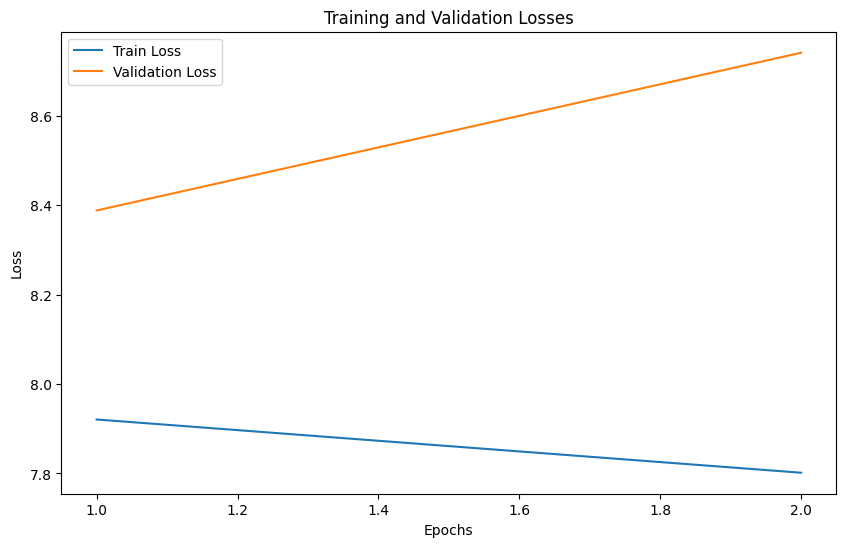

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import random
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt

class RefinedLatentDiffusion(nn.Module):
    def __init__(self, esm_model, num_steps, device):
        super().__init__()
        self.esm_model = esm_model
        self.num_steps = num_steps
        self.device = device
        self.latent_dim = esm_model.embed_dim  # Using full ESM latent space (1280)

        # CLIP model
        self.clip_model = CLIPModel(embed_dim=self.latent_dim, projection_dim=self.latent_dim)

        # Refined representation
        self.refined_representation = RefinedRepresentation(seq_len=1000)  # Adjust seq_len as needed

        # ESM attention layers for self and cross attention
        self.esm_attention_layers = nn.ModuleList([
            self.esm_model.layers[i] for i in range(-4, 0)  # Using the last 4 layers
        ])

        # Attention modules
        self.self_attention = SelfAttentionModule(self.esm_attention_layers)
        self.cross_attention = CrossAttentionModule(self.esm_attention_layers)

        # Define beta schedule
        self.beta = torch.linspace(1e-4, 0.02, num_steps).to(device)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)

        # Add epitope projection layer
        self.epitope_proj = nn.Sequential(
            nn.LazyLinear(256),
            nn.LayerNorm(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.LayerNorm(512),
            nn.Linear(512, 1024),
            nn.LeakyReLU(),
            nn.LayerNorm(1024),
            nn.Linear(1024, 1280),
        )

        # Noise prediction network (new)
        self.noise_prediction_network = nn.Sequential(
            nn.Linear(self.latent_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, self.latent_dim),
            nn.LayerNorm(self.latent_dim)
        )

        # SNR-based loss weighting parameters
        self.p2_loss_weight_k = 1
        self.p2_loss_weight_gamma = 1

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start).to(self.device)

        sqrt_alpha_bar = self.sqrt_alpha_bar[t][:, None, None]
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bar[t][:, None, None]

        x_noisy = sqrt_alpha_bar * x_start + sqrt_one_minus_alpha_bar * noise
        log_snr = torch.log(self.alpha_bar[t] / (1 - self.alpha_bar[t]))

        return x_noisy, log_snr

    def p_losses(self, ab_latent, ag_latent, epitope_latent, t, target_seq):
        noise = torch.randn_like(ab_latent).to(self.device)
        x_noisy, log_snr = self.q_sample(x_start=ab_latent, t=t, noise=noise)

        # Project epitope_latent to match ab_latent dimension
        epitope_latent = self.epitope_proj(epitope_latent)

        # Apply self and cross attention
        ag_latent = self.self_attention(ag_latent)
        x_noisy = self.self_attention(x_noisy)
        x_noisy, epitope_latent = self.cross_attention(x_noisy, epitope_latent)

        # Predict noise using the dedicated network
        predicted_noise = self.noise_prediction_network(x_noisy)

        # Calculate diffusion loss
        diff_losses = F.mse_loss(predicted_noise, noise, reduction='none')
        print('diff losses noise',noise)
        print('diff losses pred noise',predicted_noise)
        diff_losses = reduce(diff_losses, 'b ... -> b', 'mean')

        # Apply SNR-based loss weighting
        if self.p2_loss_weight_gamma >= 0:
            loss_weight = (self.p2_loss_weight_k + log_snr.exp()) ** -self.p2_loss_weight_gamma
            diff_losses = diff_losses * loss_weight

        diff_loss = diff_losses.mean()
        print('diff loss', diff_loss)
        diff_loss = torch.clamp(diff_loss, max=10.0)  # Prevent extremely large values
        print('diff loss clipped',diff_loss)

        # Calculate CLIP loss
        ab_clip, ag_clip, clip_loss = self.clip_model(ab_latent, ag_latent)

        # Calculate categorical cross-entropy loss
        logits = self.esm_model.lm_head(x_noisy)
        ce_loss = F.cross_entropy(logits.view(-1, logits.size(-1)), target_seq.view(-1))

        # Combine losses
        total_loss = diff_loss + clip_loss + ce_loss
        return total_loss, clip_loss, ce_loss, diff_loss

    @torch.no_grad()
    def p_sample(self, x, ag_latent, epitope_latent, t):
        betas_t = self.beta[t][:, None, None]
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alpha_bar[t][:, None, None]
        sqrt_recip_alphas_t = torch.sqrt(1.0 / self.alpha[t])[:, None, None]

        # Project epitope_latent to match ab_latent dimension
        epitope_latent = self.epitope_proj(epitope_latent)

        # Apply self and cross attention
        ag_latent = self.self_attention(ag_latent)  # ag<>ag self-attention
        x = self.self_attention(x)  # ab<>ab self-attention
        x, epitope_latent = self.cross_attention(x, epitope_latent)  # ab<>epitope and epitope<>ab cross-attention

        noise_pred = x - ag_latent  # Simplified noise prediction

        model_mean = sqrt_recip_alphas_t * (
            x - betas_t * noise_pred / sqrt_one_minus_alphas_cumprod_t
        )

        if t[0] > 0:
            noise = torch.randn_like(x).to(self.device)
            x0_t = model_mean + torch.sqrt(betas_t) * noise
        else:
            x0_t = model_mean

        # Dynamic thresholding (eagle and imagegen both include)
        p = 0.995  # Set this to desired percentile (e.g., 99.5%)
        s = torch.quantile(torch.abs(x0_t), p, dim=(1, 2), keepdim=True)
        s = torch.maximum(s, torch.ones_like(s))
        x0_t = torch.clip(x0_t, -s, s) / s

        return x0_t

    @torch.no_grad()
    def sample(self, ag_seq, epitope_seq, num_samples=1, guidance_scale=2.0):
        device = next(self.parameters()).device
        batch_converter = esm_model.alphabet.get_batch_converter()
        _, _, ag_tokens = batch_converter([(i, seq) for i, seq in enumerate(ag_seq)])
        _, _, epitope_tokens = batch_converter([(i, seq) for i, seq in enumerate(epitope_seq)])
        ag_tokens = ag_tokens.to(device)
        epitope_tokens = epitope_tokens.to(device)

        max_seq_length = max(ag_tokens.size(1), epitope_tokens.size(1))

        ag_tokens = pad_or_truncate(ag_tokens, max_seq_length, pad_value=esm_model.alphabet.padding_idx)
        epitope_tokens = pad_or_truncate(ag_tokens, max_seq_length, pad_value=esm_model.alphabet.padding_idx)

        ag_latent = self.esm_model(ag_tokens, repr_layers=[33], return_contacts=False)["representations"][33]
        epitope_latent = self.esm_model(epitope_tokens, repr_layers=[33], return_contacts=False)["representations"][33]

        shape = (num_samples, ag_latent.shape[1], self.latent_dim)
        x = torch.randn(shape, device=device)

        for t in reversed(range(0, self.num_steps)):
            t_batch = torch.full((num_samples,), t, device=device, dtype=torch.long)

            # Generate both conditional and unconditional samples
            x_cond = self.p_sample(x, ag_latent, epitope_latent, t_batch)
            x_uncond = self.p_sample(x, torch.zeros_like(ag_latent), torch.zeros_like(epitope_latent), t_batch)

            # Apply classifier-free guidance
            x = x_uncond + guidance_scale * (x_cond - x_uncond)

        # Convert latent to amino acid sequence
        logits = self.esm_model.lm_head(x)
        sequences = logits.argmax(dim=-1)
        return self.esm_model.decode(sequences)

class SelfAttentionModule(nn.Module):
    def __init__(self, esm_layers):
        super().__init__()
        self.esm_attention_layers = esm_layers

    def forward(self, x):
        # Create attention mask
        attention_mask = torch.ones(x.shape[0], x.shape[1], dtype=torch.bool, device=x.device)

        for esm_layer in self.esm_attention_layers:
            # Transpose x to match ESM's expected format: (seq_length, batch_size, embed_dim)
            x = x.transpose(0, 1)

            # Apply self-attention
            residual = x
            x = esm_layer.self_attn_layer_norm(x)
            x, _ = esm_layer.self_attn(
                query=x,
                key=x,
                value=x,
                key_padding_mask=~attention_mask,
                need_weights=False
            )
            x = residual + x

            # Apply feed-forward network
            residual = x
            x = esm_layer.final_layer_norm(x)
            x = esm_layer.fc1(x)
            x = F.gelu(x)
            x = esm_layer.fc2(x)
            x = residual + x

            # Transpose x back to (batch_size, seq_length, embed_dim)
            x = x.transpose(0, 1)

        return x

class CrossAttentionModule(nn.Module):
    def __init__(self, esm_layers):
        super().__init__()
        self.esm_attention_layers = esm_layers

    def forward(self, ab_latent, epitope_latent):
        # Transpose to match ESM's expected format: (seq_length, batch_size, embed_dim)
        ab_latent = ab_latent.transpose(0, 1)
        epitope_latent = epitope_latent.transpose(0, 1)

        for esm_layer in self.esm_attention_layers:
            # Cross-attention of ab to epitope
            ab_residual = ab_latent
            ab_latent = esm_layer.self_attn_layer_norm(ab_latent)
            ab_latent, _ = esm_layer.self_attn(
                query=ab_latent,
                key=epitope_latent,
                value=epitope_latent,
                need_weights=False
            )
            ab_latent = ab_residual + ab_latent

            # Cross-attention of epitope to ab
            epitope_residual = epitope_latent
            epitope_latent = esm_layer.self_attn_layer_norm(epitope_latent)
            epitope_latent, _ = esm_layer.self_attn(
                query=epitope_latent,
                key=ab_latent,
                value=ab_latent,
                need_weights=False
            )
            epitope_latent = epitope_residual + epitope_latent

            # Apply feed-forward networks
            ab_latent = self._apply_feed_forward(esm_layer, ab_latent)
            epitope_latent = self._apply_feed_forward(esm_layer, epitope_latent)

        # Transpose back to (batch_size, seq_length, embed_dim)
        ab_latent = ab_latent.transpose(0, 1)
        epitope_latent = epitope_latent.transpose(0, 1)
        return ab_latent, epitope_latent

    def _apply_feed_forward(self, esm_layer, x):
        residual = x
        x = esm_layer.final_layer_norm(x)
        x = esm_layer.fc1(x)
        x = F.gelu(x)
        x = esm_layer.fc2(x)
        x = residual + x
        return x

class CLIPModel(nn.Module):
    def __init__(self, embed_dim, projection_dim):
        super().__init__()
        self.ab_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=8),
            num_layers=3
        )
        self.ag_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=8),
            num_layers=3
        )
        self.project_ab = nn.Linear(embed_dim, projection_dim)
        self.project_ag = nn.Linear(embed_dim, projection_dim)

    def forward(self, ab_emb, ag_emb):
        ab_vec = self.ab_encoder(ab_emb)
        ag_vec = self.ag_encoder(ag_emb)

        ab_embed = F.normalize(self.project_ab(ab_vec[:, 0]), dim=-1)
        ag_embed = F.normalize(self.project_ag(ag_vec[:, 0]), dim=-1)

        # Symmetrical CLIP loss
        similarity = torch.matmul(ab_embed, ag_embed.t())
        labels = torch.arange(similarity.size(0)).to(similarity.device)
        loss_i = F.cross_entropy(similarity, labels)
        loss_t = F.cross_entropy(similarity.t(), labels)
        clip_loss = (loss_i + loss_t) / 2

        return ab_embed, ag_embed, clip_loss

class RefinedRepresentation(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.seq_len = seq_len

    def forward(self, tokens, energy_scores):
        # One-hot encoding
        one_hot = F.one_hot(tokens, num_classes=len(esm_model.alphabet))
        # Binary motif channel
        motif_channel = (energy_scores <= -1).float().unsqueeze(-1)
        # Combine representations
        combined = torch.cat([one_hot, motif_channel], dim=-1)
        return combined


def pad_or_truncate(tensor, target_length, pad_value=0):
    current_length = tensor.size(1)
    if current_length < target_length:
        padding = torch.full((tensor.size(0), target_length - current_length, *tensor.size()[2:]), pad_value, device=tensor.device)
        return torch.cat([tensor, padding], dim=1)
    else:
        return tensor[:, :target_length]

def train_clip(model, esm_model, train_loader, val_loader, optimizer, num_epochs, device):
    wandb.init(project="protein_binding_clip", entity="vskavi2003")
    wandb.config.update({
        "learning_rate": optimizer.param_groups[0]['lr'],
        "epochs": num_epochs,
        "batch_size": train_loader.batch_size
    })

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for batch in tqdm(train_loader, desc=f"CLIP Epoch {epoch+1}/{num_epochs}"):
            energy_scores, protein_seq, peptide_seq = batch
            energy_scores = energy_scores.to(device)
            protein_tokens = protein_seq.to(device)
            peptide_tokens = peptide_seq.to(device)
            protein_onehot = F.one_hot(protein_tokens, num_classes=len(esm_model.alphabet)).float()

            with torch.no_grad():
                protein_embedding = esm_model(protein_tokens, repr_layers=[33], return_contacts=False)["representations"][33]
                peptide_embedding = esm_model(peptide_tokens, repr_layers=[33], return_contacts=False)["representations"][33]

            _, _, clip_loss = model(peptide_embedding, protein_embedding)

            optimizer.zero_grad()
            clip_loss.backward()
            optimizer.step()

            total_train_loss += clip_loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                energy_scores, protein_seq, peptide_seq = batch
                energy_scores = energy_scores.to(device)
                protein_tokens = protein_seq.to(device)
                peptide_tokens = peptide_seq.to(device)
                protein_onehot = F.one_hot(protein_tokens, num_classes=len(esm_model.alphabet)).float()

                protein_embedding = esm_model(protein_tokens, repr_layers=[33], return_contacts=False)["representations"][33]
                peptide_embedding = esm_model(peptide_tokens, repr_layers=[33], return_contacts=False)["representations"][33]

                _, _, val_clip_loss = model(peptide_embedding, protein_embedding)
                total_val_loss += val_clip_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        wandb.log({
            "epoch": epoch+1,
            "clip_train_loss": avg_train_loss,
            "clip_val_loss": avg_val_loss
        })

        print(f"CLIP Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

def validate(model, dataloader, device):
    model.eval()
    total_loss = 0
    total_diff_loss = 0
    total_clip_loss = 0
    total_ce_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            energy_scores, protein_seq, peptide_seq = batch
            energy_scores = energy_scores.to(device)
            protein_tokens = protein_seq.to(device)
            peptide_tokens = peptide_seq.to(device)
            protein_onehot = F.one_hot(protein_tokens, num_classes=len(model.esm_model.alphabet)).float()

            protein_embedding = esm_model(protein_tokens, repr_layers=[33], return_contacts=False)["representations"][33]
            peptide_embedding = esm_model(peptide_tokens, repr_layers=[33], return_contacts=False)["representations"][33]

            epitope_latent = model.refined_representation(protein_tokens, (energy_scores <= -1).float())

            t = torch.randint(0, model.num_steps, (protein_embedding.shape[0],), device=device).long()
            loss, clip_loss, ce_loss, diff_loss = model.p_losses(peptide_embedding, protein_embedding, epitope_latent, t, peptide_tokens)

            total_loss += loss.item()
            total_clip_loss += clip_loss.item()
            total_ce_loss += ce_loss.item()
            total_diff_loss += (loss - clip_loss - ce_loss).item()

    avg_loss = total_loss / len(dataloader)
    avg_diff_loss = total_diff_loss / len(dataloader)
    avg_clip_loss = total_clip_loss / len(dataloader)
    avg_ce_loss = total_ce_loss / len(dataloader)

    return avg_loss, avg_diff_loss, avg_clip_loss, avg_ce_loss

def train(model, train_loader, val_loader, optimizer, num_epochs, device):
    wandb.init(project="protein_binding_diffusion", entity="vskavi2003")
    wandb.config.update({
        "learning_rate": optimizer.param_groups[0]['lr'],
        "epochs": num_epochs,
        "batch_size": train_loader.batch_size
    })

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        total_train_diff_loss = 0
        total_train_clip_loss = 0
        total_train_ce_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            energy_scores, protein_seq, peptide_seq = batch
            energy_scores = energy_scores.to(device)
            protein_tokens = protein_seq.to(device)
            peptide_tokens = peptide_seq.to(device)

            protein_onehot = F.one_hot(protein_tokens, num_classes=len(model.esm_model.alphabet)).float()

            protein_embedding = esm_model(protein_tokens, repr_layers=[33], return_contacts=False)["representations"][33]
            peptide_embedding = esm_model(peptide_tokens, repr_layers=[33], return_contacts=False)["representations"][33]

            epitope_latent = model.refined_representation(protein_tokens, (energy_scores <= -1).float())

            # Implement classifier-free guidance
            if random.random() < 0.1:  # 10% of the time, remove antigen conditioning
                protein_embedding = torch.zeros_like(protein_embedding)
                epitope_latent = torch.zeros_like(epitope_latent)

            t = torch.randint(0, model.num_steps, (protein_embedding.shape[0],), device=device).long()
            loss, clip_loss, ce_loss, diff_loss = model.p_losses(peptide_embedding, protein_embedding, epitope_latent, t, peptide_tokens)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train_clip_loss += clip_loss.item()
            total_train_ce_loss += ce_loss.item()
            total_train_diff_loss += (loss - clip_loss - ce_loss).item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_diff_loss = total_train_diff_loss / len(train_loader)
        avg_train_clip_loss = total_train_clip_loss / len(train_loader)
        avg_train_ce_loss = total_train_ce_loss / len(train_loader)

        val_loss, val_diff_loss, val_clip_loss, val_ce_loss = validate(model, val_loader, device)

        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)

        wandb.log({
            "epoch": epoch+1,
            "train_loss": avg_train_loss,
            "train_diff_loss": avg_train_diff_loss,
            "train_clip_loss": avg_train_clip_loss,
            "train_ce_loss": avg_train_ce_loss,
            "val_loss": val_loss,
            "val_diff_loss": val_diff_loss,
            "val_clip_loss": val_clip_loss,
            "val_ce_loss": val_ce_loss
        })

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.savefig('loss_plot.png')
    wandb.log({"loss_plot": wandb.Image('loss_plot.png')})

def generate_random_protein_binders(model, num_samples=5, seq_length=100):
    device = next(model.parameters()).device

    # Generate random protein sequence
    protein_seq = ''.join(random.choice('ACDEFGHIKLMNPQRSTVWY') for _ in range(seq_length))

    # Generate random epitope (motif)
    epitope_start = random.randint(0, seq_length - 10)
    epitope_end = epitope_start + random.randint(5, 10)
    epitope_seq = protein_seq[epitope_start:epitope_end]

    # Generate binders
    generated_binders = model.sample(protein_seq, epitope_seq, num_samples=num_samples)

    return protein_seq, epitope_seq, generated_binders

def custom_collate_fn(batch):
    energy_scores, protein_seqs, peptide_seqs = zip(*batch)
    batch_converter = esm_model.alphabet.get_batch_converter()
    _, _, protein_tokens = batch_converter([(i, seq) for i, seq in enumerate(protein_seqs)])
    _, _, peptide_tokens = batch_converter([(i, seq) for i, seq in enumerate(peptide_seqs)])

    padded_energy_scores = [F.pad(torch.tensor(score, dtype=torch.float32), (1, 1), value=0) for score in energy_scores]

    max_seq_length = max(protein_tokens.size(1), peptide_tokens.size(1))

    padded_energy_scores = torch.stack([
        pad_or_truncate(score.unsqueeze(0), max_seq_length, pad_value=0).squeeze(0)
        for score in padded_energy_scores
    ])

    padded_protein_tokens = pad_or_truncate(protein_tokens, max_seq_length, pad_value=esm_model.alphabet.padding_idx)

    padded_peptide_tokens = pad_or_truncate(peptide_tokens, max_seq_length, pad_value=esm_model.alphabet.padding_idx)

    return padded_energy_scores, padded_protein_tokens, padded_peptide_tokens

def main():
    # Load and preprocess data
    train_snp = preprocess_snp_data('training_dataset.csv')
    val_snp = preprocess_snp_data('validation_dataset.csv')
    test_snp = preprocess_snp_data('testing_dataset.csv')

    train_snp = filter_datasets(train_snp)
    val_snp = filter_datasets(val_snp)
    test_snp = filter_datasets(test_snp)

    train_snp, val_snp, test_snp = train_snp[:32], val_snp[:16], test_snp[:16] # subset code

    # Create datasets
    train_dataset = ProteinInteractionDataset(train_snp)
    val_dataset = ProteinInteractionDataset(val_snp)
    test_dataset = ProteinInteractionDataset(test_snp)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=custom_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=4, collate_fn=custom_collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=4, collate_fn=custom_collate_fn)

    # Initialize model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_steps = 1000
    model = RefinedLatentDiffusion(esm_model, num_steps, device).to(device)

    # Train CLIP model
    clip_optimizer = torch.optim.Adam(model.clip_model.parameters(), lr=1e-5)
    train_clip(model.clip_model, esm_model, train_loader, val_loader, clip_optimizer, num_epochs=2, device=device)

    # Train Latent Diffusion model
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    train_losses, val_losses = train(model, train_loader, val_loader, optimizer, num_epochs=2, device=device)

    # Plot losses
    plot_losses(train_losses, val_losses)

    # Save the trained model
    torch.save(model.state_dict(), 'protein_binder_model.pth')

    # # Generate examples
    # print("Generating protein binders for random cases:")
    # for i in range(3):
    #     protein_seq, epitope_seq, generated_binders = generate_random_protein_binders(model)
    #     print(f"\nCase {i+1}:")
    #     print(f"Protein sequence: {protein_seq}")
    #     print(f"Epitope sequence: {epitope_seq}")
    #     print("Generated binders:")
    #     for j, binder in enumerate(generated_binders):
    #         print(f"Binder {j+1}: {binder}")

if __name__ == "__main__":
    main()
